## Setup

In [1]:
# Load packages
using DifferentialEquations
using Plots, StatsPlots
using CSV, DataFrames
using Turing
using LaTeXStrings
using XLSX
using Optim
using StatsBase
using Random
using KernelDensity
using ProgressMeter
using Distributions
using Measures
using GLM

# Setup plots standard
Plots.default(fontfamily = ("computer modern"))

# Set seed 
Random.seed!(42)

TaskLocalRNG()

In [2]:
# Add rhs file
include("model_rhs.jl")
    
# Add parameter file
include("model_default_param.jl")

# Add treatment rhs
include("model_rhs_treatment.jl")

# Add function for calculating VAF
include("model_calc_VAF.jl")

# Add model for Turing inference - individual
include("model_infer_dynamics.jl")

# Add model for Turing inference - hierarchical
include("model_infer_dynamics_Hierarchical_Gibbs_DALIAH.jl")

# Add model function for Turing optimisation
include("model_infer_dynamics_post_Hierarchical.jl")

model_infer_dynamics_post_Hierarchical

In [3]:
# Setup initial conditions for master curve
x00 = 1.0*10^5
x10 = 2.5*10^6
x20 = 6.4*10^11
y00 = 1
y10 = 0
y20 = 0
a0 = 8.1*10^2
s0 = 1

# Collect in one vector
u0 = [x00,x10,x20,y00,y10,y20,a0,s0]

# Setup and solve ODEproblem
tspan = (0.0,90*365)
prob = ODEProblem(model_rhs, u0, tspan, p)
sol = solve(prob, TRBDF2(), reltol = 1e-10, abstol = 1e-10, saveat=1)

# Save as named tuple
master_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))

(t = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  32841.0, 32842.0, 32843.0, 32844.0, 32845.0, 32846.0, 32847.0, 32848.0, 32849.0, 32850.0], x0 = [100000.0, 99999.28014604042, 99998.58099317514, 99997.90054517318, 99997.2361247567, 99996.58543544661, 99995.94650693233, 99995.31764842379, 99994.69740877306, 99994.0845423813  …  1.8609987268004509, 1.8600391708260122, 1.859080109644587, 1.8581215430323301, 1.8571634706299531, 1.8562058922481908, 1.855248807523938, 1.8542922162899567, 1.85333611836694, 1.8523805134158782], x1 = [2.5e6, 2.499892552031063e6, 2.4997848422058923e6, 2.4996769420471084e6, 2.4995689453848847e6, 2.4994609323745994e6, 2.4993529714592863e6, 2.4992451210456532e6, 2.4991374309370755e6, 2.499029943558893e6  …  58.85223884536521, 58.82189390263089, 58.791564607190864, 58.761250952072494, 58.73095292584728, 58.700670522809894, 58.67040373102239, 58.640152545142634, 58.609916959557594, 58.57969696360518], x2 = [6.4e11, 6.406571135075917e11, 6.412179399621925e11,

## Data

In [4]:
# Setup dataframes
df_D = DataFrame

# Load data
path = "M:/data_cancer/DALIAH/Trine_DALIAH_5y/DALIAH_5y - Export for Julia.csv"
df_D = CSV.read(path, df_D)

# Change data types
df_D[!,:days] = convert.(Float64,df_D[:,:days])
df_D[!,:RUX] = convert.(Float64,df_D[:,:RUX])


df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


In [5]:
# Convert to starting at time for first data point - no matter if JAK or treatment
for i in unique(df_D.patientID)
    # Set pID
    pID = i
    
    # Extract minimum number of days - where IFN>0 or JAK>=0
    df_p = df_D[df_D.patientID .== pID,:]

    minDays = minimum(df_p.days[df_p.IFN .> 0  .|| df_p.JAK .>= 0, :])
    
    # Subtract minimum number of days
    df_D.days[df_D.patientID .== pID, :] = df_D.days[df_D.patientID .== pID, :] .- minDays
end
df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


In [6]:
# Define new patients
# new_patients = [22,112,132,163,179,200]
# new_patients = [11,20,44,84,85,103,108,111,114,137,139,145,147,149]
new_patients = [6,16,25,27,44,45,82,102,108,122,126,160,179,200]

14-element Vector{Int64}:
   6
  16
  25
  27
  44
  45
  82
 102
 108
 122
 126
 160
 179
 200

## Calculate for all patients and all data points

In [7]:
# Unique patients
unique_patients = new_patients

# Number of patients
P = length(unique_patients)

# Plot for all patients in loop
@showprogress dt=1 desc="Calculating results for all patients and all data points..." for i=1:P 
    # Extract relevant data
    pID = unique_patients[i]
    df_p = df_D[df_D.patientID .== pID, :]
    
    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK
    
    # Use only data at which VAF is not NaN
    pVAF = pVAF[.!isnan.(pVAF)]
    
    # Length of pVAF
    J = length(pVAF)

    # Choose treatment effect
    effect = "py0dy1"

    # Chooase to estimate initJAK as well
    estInitJAK = true
    
    # Sample in loop over number of data points
    for j=1:J
        # Extract VAF
        pVAF = df_p.JAK
        
        # Use only data at which VAF is not NaN
        pVAF = pVAF[.!isnan.(pVAF)]

        # Use choose how many data points to use
        nData = j
        pVAF = pVAF[1:nData]

        # Instantiate model
        model = model_infer_dynamics_post_Hierarchical(pVAF,df_p,effect,p,master_curve,estInitJAK)

        # Set seed 
        Random.seed!(42)

        # Sample using Turing
        MCMC = sample(model, HMC(0.05, 10), 10500)

        # Convert to data frame
        df_MCMC = DataFrame(MCMC)
        
        path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Individual/Post Hierarchical/MCMC_py0dy1_p$(pID)_$(j).csv"
        CSV.write(path, df_MCMC)
    end
end

Sampling: 100%|█████████████████████████████████████████| Time: 0:06:41
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:53
Sampling: 100%|█████████████████████████████████████████| Time: 0:09:21
Sampling: 100%|█████████████████████████████████████████| Time: 0:09:12
Sampling: 100%|█████████████████████████████████████████| Time: 0:08:16
Sampling: 100%|█████████████████████████████████████████| Time: 0:08:09
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:54
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:36
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:50
Sampling: 100%|█████████████████████████████████████████| Time: 

## Plot for all patients and all data points

In [7]:
# Unique patients
unique_patients = new_patients

# Number of patients
P = length(unique_patients)

# Maximum number of observations
maxObs = 9

# Storage
RMSE_mat = NaN*ones(P,maxObs)
meanCIwidth_mat = NaN*ones(P,maxObs)

# Plot for all patients in loop
@showprogress dt=1 desc="Plotting results for all patients and all data points..." for i=1:P 
    # Extract relevant data
    pID = unique_patients[i]
    df_p = df_D[df_D.patientID .== pID, :]
    
    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK
    
    # Use only data at which VAF is not NaN
    pVAF = pVAF[.!isnan.(pVAF)]
    
    # Length of pVAF
    J = length(pVAF)

    # Choose treatment effect
    effect = "py0dy1"

    # Choose time for calculating VAF
    pDays = 0:1:75*30.4
    pDays2 = df_p.days[.!isnan.(df_p.JAK)]
    pVAF2 = df_p.JAK[.!isnan.(df_p.JAK)]
    pDays_plot = pDays[1:30:end]

    # Chooase to estimate initJAK as well
    estInitJAK = true
    
    # Plot in loop for all data points
    for j=1:J
        # Extract VAF
        pVAF = df_p.JAK
        
        # Use only data at which VAF is not NaN
        pVAF = pVAF[.!isnan.(pVAF)]

        # Use choose how many data points to use
        nData = j
        pVAF = pVAF[1:nData]

        # Load results
        df_MCMC = DataFrame
        path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Individual/Post Hierarchical/MCMC_py0dy1_p$(pID)_$(j).csv"
        df_MCMC = CSV.read(path, df_MCMC)
        
        # Remove burn-in
        deleteat!(df_MCMC,collect(1:500))

        # Storage
        VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
        VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
        p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

        # Calculate VAF in loop
        @showprogress dt=1 desc="Calculating VAF for MCMC chain..." for k in eachindex(df_MCMC.rho1)
            # Set rho values
            rho = [df_MCMC.rho1[k], df_MCMC.rho2[k]]

            # Set initial JAK
            initJAK = df_MCMC.initJAK[k]

            # Calculate VAF using function
            VAF_mat[:,k], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
            VAF_mat_points[:,k], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
            p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
                       a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
            p_mat[:,k,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
        end
        VAF_mat_plot = VAF_mat[1:30:end,:]

        # Calculate RMSE based on mean at the points
        RMSE = rmsd(median(VAF_mat_points, dims=2),df_p.JAK[.!isnan.(df_p.JAK)])
        
        # Save result
        RMSE_mat[i,j] = RMSE
        
        # Calculate mean width of 95% CI
        mean_width = mean(abs.(quantile.(eachrow(VAF_mat), 0.975)*100-quantile.(eachrow(VAF_mat), 0.025)*100))
        
        # Save result
        meanCIwidth_mat[i,j] = mean_width

        # Calculate mean parameter values
        median_param_1 = median(df_MCMC[:,"rho1"])
        median_param_2 = median(df_MCMC[:,"rho2"])
        
        # Plot results
        figVAF = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
            linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
          linewidth = 3, label = "", colour= :blue1)
        title!(L"JAK2"*" VAF for Patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho="
               *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)

        p2 = twinx()
        plot!(p2, pDays_plot/30.4, quantile.(eachrow(VAF_mat_plot), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat_plot), 0.975)*100, fillalpha = 0.35, 
             colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
#         plot!(p2, pDays[pDays.<=maxDays]/30.4, mean(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
#                  label = L"JAK2"*" VAF - Mean", colour = :darkgoldenrod1)
#         plot!(p2, pDays[pDays.>maxDays]/30.4, mean(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
#               label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
        plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, median(VAF_mat_plot[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 3, 
              label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
        plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, median(VAF_mat_plot[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 3, 
              label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
        scatter!(p2, pDays2[1:nData]./30.4, pVAF2[1:nData]*100, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
        scatter!(p2, pDays2[nData+1:end]./30.4, pVAF2[nData+1:end]*100, label=L"\textrm{Data}", markercolor=:magenta3, markershape=:diamond, markersize=4, markerstrokewidth=0.25)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        plot!(titlefont=18,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        
        # Save figure
        figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MCMC - Post Hierarchical/"
        savefig(figVAF,figpath*"Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).png")
        savefig(figVAF,figpath*"Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).pdf")
        savefig(figVAF,figpath*"Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).svg")
        
        # Plot density
        l = @layout [a a; a a; a a; a a;]
        plot_rho1_chain = plot(df_MCMC.iteration,df_MCMC.rho1,linewidth = 0.5, colour = 1, label = "")
        title!("\nChain for "*L"\rho_{s_{y_0}}")
        xlabel!("Iteration")
        ylabel!(L"\rho/1")
        plot_rho1_density = plot(density(df_MCMC.rho1,legend=false),linewidth = 0.5, colour = 1, label = "")
        xlims!(0, 1)
        title!("\nDensity for "*L"\rho")
        xlabel!(L"\rho/1")
        ylabel!("pdf/1")
        plot_rho2_chain = plot(df_MCMC.iteration,df_MCMC.rho2,linewidth = 0.5, colour = 1, label = "")
        title!("Chain for "*L"\delta")
        xlabel!("Iteration")
        ylabel!(L"\rho_{p_{y_1}}/\textrm{day}^{-1}")
        plot_rho2_density = plot(density(df_MCMC.rho2,legend=false),linewidth = 0.5, colour = 1, label = "")
        xlims!(0, 1)
        title!("Density for "*L"\delta")
        xlabel!(L"\rho_{p_{y_1}}/\textrm{day}^{-1}")
        ylabel!("pdf/1")
        plot_initJAK_chain = plot(df_MCMC.iteration,df_MCMC.initJAK*100,linewidth = 0.5, colour = 1, label = "")
        title!("Chain for Initial VAF")
        xlabel!("Iteration")
        ylabel!("Initial VAF/%")
        plot_initJAK_density = plot(density(df_MCMC.initJAK*100,legend=false),linewidth = 0.5, colour = 1, label = "")
        xlims!(0, 100)
        title!("Density for "*"Initial VAF")
        xlabel!("Initial VAF/%")
        ylabel!("pdf/1")
        plot_sigma_chain = plot(df_MCMC.iteration,df_MCMC.sigma*100, linewidth = 0.5, colour = 1, label = "")
        title!("Chain for "*L"\sigma")
        xlabel!("Iteration")
        ylabel!(L"\sigma/\%")
        plot_sigma_density = plot(density((df_MCMC.sigma*100),legend=false),linewidth = 0.5, colour = 1, label = "")
        xlims!(0, 60)
        title!("Density for "*L"\sigma")
        xlabel!(L"\sigma/\%")
        ylabel!("pdf/1")
        figMCMC = plot(plot_rho1_chain,plot_rho1_density,plot_rho2_chain,plot_rho2_density,plot_initJAK_chain,plot_initJAK_density,
            plot_sigma_chain,plot_sigma_density,layout = l,size = (700, 1000))
        
        # Save figure
        figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MCMC - Post Hierarchical/"
        savefig(figMCMC,figpath*"Chain_Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).png")
        savefig(figMCMC,figpath*"Chain_Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).pdf")
        savefig(figMCMC,figpath*"Chain_Individual_MCMC_$(effect)_post_Hierarchical_$(pID)_$(j).svg")
    end
end

Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:01:00
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:53
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:57
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:01:03
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:01:29
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:01:45
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:01:04
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:55
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:43
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:42
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:47
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:40
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:43
Calculating VAF for MCMC chain... 100%|████████████

Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:32
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:32
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:34
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:31
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:30
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:29
Plotting results for all patients and all data points... 100% Time: 1:12:08


In [40]:
# Plot all data points for a patient in same figure

# Create empty plots
plot1 = plot()
plot2 = plot()
plot3 = plot()
plot4 = plot()
plot5 = plot()
plot6 = plot()
plot7 = plot()
plot8 = plot()
plot9 = plot()

# Unique patients
unique_patients = new_patients

# Number of patients
P = length(unique_patients)

# Maximum number of observations
maxObs = 9

# Plot for all patients in loop
@showprogress dt=1 desc="Plotting results for all patients and all data points..." for i=11:11 
    # Extract relevant data
    pID = unique_patients[i]
    df_p = df_D[df_D.patientID .== pID, :]
    
    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK
    
    # Use only data at which VAF is not NaN
    pVAF = pVAF[.!isnan.(pVAF)]
    
    # Length of pVAF
    J = length(pVAF)

    # Choose treatment effect
    effect = "py0dy1"

    # Choose time for calculating VAF
    pDays = 0:1:75*30.4
    pDays2 = df_p.days[.!isnan.(df_p.JAK)]
    pVAF2 = df_p.JAK[.!isnan.(df_p.JAK)]
    pDays_plot = pDays[1:30:end]

    # Chooase to estimate initJAK as well
    estInitJAK = true
    
    # Plot in loop for all data points
    for j=1:J
        # Extract VAF
        pVAF = df_p.JAK
        
        # Use only data at which VAF is not NaN
        pVAF = pVAF[.!isnan.(pVAF)]

        # Use choose how many data points to use
        nData = j
        pVAF = pVAF[1:nData]

        # Load results
        df_MCMC = DataFrame
        path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Individual/Post Hierarchical/MCMC_py0dy1_p$(pID)_$(j).csv"
        df_MCMC = CSV.read(path, df_MCMC)
        
        # Remove burn-in
        deleteat!(df_MCMC,collect(1:500))

        # Storage
        VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
        VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
        p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

        # Calculate VAF in loop
        @showprogress dt=1 desc="Calculating VAF for MCMC chain..." for k in eachindex(df_MCMC.rho1)
            # Set rho values
            rho = [df_MCMC.rho1[k], df_MCMC.rho2[k]]

            # Set initial JAK
            initJAK = df_MCMC.initJAK[k]

            # Calculate VAF using function
            VAF_mat[:,k], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
            VAF_mat_points[:,k], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
            p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
                       a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
            p_mat[:,k,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
        end
        VAF_mat_plot = VAF_mat[1:30:end,:]

        # Calculate RMSE based on mean at the points
        RMSE = rmsd(mean(VAF_mat_points, dims=2),df_p.JAK[.!isnan.(df_p.JAK)])
         
        # Calculate mean width of 95% CI
        mean_width = mean(abs.(quantile.(eachrow(VAF_mat), 0.975)*100-quantile.(eachrow(VAF_mat), 0.025)*100))
        
        # Calculate mean parameter values
        median_param_1 = median(df_MCMC[:,"rho1"])
        median_param_2 = median(df_MCMC[:,"rho2"])
        
        # Load results
        df_MCMC = DataFrame
        path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Individual/Pre Hierarchical/MCMC_py0dy1_p$(pID)_$(j).csv"
        df_MCMC = CSV.read(path, df_MCMC)
        
        # Remove burn-in
        deleteat!(df_MCMC,collect(1:500))

        # Storage
        VAF_mat_pre = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
        VAF_mat_points_pre = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
        p_mat_pre = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

        # Calculate VAF in loop - pre hierarchical
        @showprogress dt=1 desc="Calculating VAF for MCMC chain..." for k in eachindex(df_MCMC.rho1)
            # Set rho values
            rho = [df_MCMC.rho1[k], df_MCMC.rho2[k]]

            # Set initial JAK
            initJAK = df_MCMC.initJAK[k]

            # Calculate VAF using function
            VAF_mat_pre[:,k], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
            VAF_mat_points_pre[:,k], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
            p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
                       a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
            p_mat_pre[:,k,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
        end
        VAF_mat_plot_pre = VAF_mat_pre[1:30:end,:]
        
        # Plot results
        figVAF = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
            linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
          linewidth = 3, label = "", colour= :blue1)
        if j==1
            title!(L"JAK2"*" VAF for Patient $(pID) using \n the first data point, RMSE = $(round(RMSE; sigdigits=3)),\n "*L"\rho="
                   *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
        else
            title!(L"JAK2"*" VAF for Patient $(pID) using \n the first $(j) data points, RMSE = $(round(RMSE; sigdigits=3)),\n "*L"\rho="
               *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
        end
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)
        p2 = twinx()
        plot!(p2, pDays_plot/30.4, quantile.(eachrow(VAF_mat_plot), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat_plot), 0.975)*100, fillalpha = 0.35, 
             colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
#         plot!(p2, pDays[pDays.<=maxDays]/30.4, mean(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
#                  label = L"JAK2"*" VAF - Mean", colour = :darkgoldenrod1)
#         plot!(p2, pDays[pDays.>maxDays]/30.4, mean(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
#               label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
        plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, median(VAF_mat_plot_pre[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 6, 
              label = L"JAK2"*" VAF - Median", colour = :blue1)
        plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, median(VAF_mat_plot_pre[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 6, 
              label = L"JAK2"*" VAF - Median prediction", colour = :blue1, linestyle = :dash)
        plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, median(VAF_mat_plot[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 6, 
              label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
        plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, median(VAF_mat_plot[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 6, 
              label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
        scatter!(p2, pDays2[1:nData]./30.4, pVAF2[1:nData]*100, label=L"\textrm{Data}", markercolor=:red, markersize=6, markerstrokewidth=0.1)
        scatter!(p2, pDays2[nData+1:end]./30.4, pVAF2[nData+1:end]*100, label=L"\textrm{Data}", markercolor=:magenta3, markershape=:diamond, markersize=6, markerstrokewidth=0.1)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        if j==1
            plot1 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==2
            plot2 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==3
            plot3 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==4
            plot4 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==5
            plot5 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==6
            plot6 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==7
            plot7 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==8
            plot8 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        elseif j==9
            plot9 = plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none, margin = 5mm, 
              leftmargin = 8mm, rightmargin = 8mm)
        end
    end
end

Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:31
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:37
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:33
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:38
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:34
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:40
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:31
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:35
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:33
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:35
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:37
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:38
Calculating VAF for MCMC chain... 100%|██████████████████| Time: 0:00:37
Calculating VAF for MCMC chain... 100%|████████████

In [42]:
# Plot combined figure
figcombined = plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9,
                layout=grid(3, 3), link =:x, size = (1600, 1600), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MCMC - Post Hierarchical/"
savefig(figcombined,figpath*"Individual_MCMC_py0dy1_post_Hierarchical_126_all.png")
savefig(figcombined,figpath*"Individual_MCMC_py0dy1_post_Hierarchical_126_all.pdf")
savefig(figcombined,figpath*"Individual_MCMC_py0dy1_post_Hierarchical_126_all.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Individual\\MCMC - Post Hierarchical\\Individual_MCMC_py0dy1_post_Hierarchical_126_all.svg"

## Compare to results usig uniform priors

In [11]:
# Load results from pre hierarchical
df_RMSE_vec_pre = DataFrame
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/RMSE_test_train.csv"
df_RMSE_vec_pre = CSV.read(path, df_RMSE_vec_pre)
df_meanCIwidth_vec_pre = DataFrame
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/CI_test_train.csv"
df_meanCIwidth_vec_pre = CSV.read(path, df_meanCIwidth_vec_pre)

# Convert to matrices
RMSE_mat_pre = Matrix(df_RMSE_vec_pre)
meanCIwidth_mat_pre = Matrix(df_meanCIwidth_vec_pre)

14×9 Matrix{Float64}:
 58.2772  29.1469   21.7492    …    3.05064     3.21099   NaN
 51.8382  38.6753   37.5765        10.3545      6.86089     4.84345
 69.3743  38.3031   15.324        NaN         NaN         NaN
 39.7441  26.3874   18.5545         3.50512     3.8636      5.15514
 76.3432  65.4263   58.3168         9.61109   NaN         NaN
 81.0206  74.5382   64.3122    …   27.0165    NaN         NaN
 39.0437  14.679     8.48251       16.0896     11.4332    NaN
 47.0243  42.2013   36.3378        29.4488     14.4095     11.6914
 61.1743  63.8533   61.9317        34.6643     23.9334     17.5574
 69.2813  40.969    38.6036       NaN         NaN         NaN
 86.9682  83.0277   71.2426    …   22.822      23.2399     21.4652
 46.8227  39.0319   30.7889        17.5881     14.8518     12.0901
 78.6267  67.3      68.5387       NaN         NaN         NaN
 50.9206   9.53361   0.513111       0.200676    0.165396    0.146782

In [12]:
## Storage
mean_RMSE_vec = NaN*ones(maxObs)
mean_meanCIwidth_vec = NaN*ones(maxObs)
mean_RMSE_vec_pre = NaN*ones(maxObs)
mean_meanCIwidth_vec_pre = NaN*ones(maxObs)

# Calculate means in loop
for i=1:maxObs
    temp = RMSE_mat[:,i]
    mean_RMSE_vec[i] = mean(temp[.!(isnan.(temp))])
    temp = meanCIwidth_mat[:,i]
    mean_meanCIwidth_vec[i] = mean(temp[.!(isnan.(temp))])
    temp = RMSE_mat_pre[:,i]
    mean_RMSE_vec_pre[i] = mean(temp[.!(isnan.(temp))])
    temp = meanCIwidth_mat_pre[:,i]
    mean_meanCIwidth_vec_pre[i] = mean(temp[.!(isnan.(temp))])
end

In [13]:
mean_RMSE_vec

9-element Vector{Float64}:
 0.09905524075101753
 0.08492676820928009
 0.0782939443094715
 0.0628515530601279
 0.04626189796539646
 0.03723569850942383
 0.031834697692043175
 0.025661277347899147
 0.028214906483910344

In [14]:
mean_meanCIwidth_vec

9-element Vector{Float64}:
 74.45706715084714
 52.85037661456003
 39.750546362486276
 34.06185781566369
 28.77762373997597
 19.7758539113221
 14.059958723311775
 10.217179138241185
  9.686926502343482

In [23]:
# Setup for all patients
RMSE_plot = Any[]

# Plot RMSEs in loop
for i=1:length(unique_patients)
    fig1 = plot()
    plot!([1:9], RMSE_mat_pre[i,:], linewidth = 3, label = "Uniform prior", colour= :blue1, xticks = (1:maxObs, 1:maxObs), 
           linestyle = :dash)
    plot!([1:9], RMSE_mat[i,:], linewidth = 3, label = "Population prior", colour= :darkgoldenrod1, xticks = (1:maxObs, 1:maxObs))
    scatter!([1:9], RMSE_mat_pre[i,:], markercolor=:blue1, markersize=4, markerstrokewidth=0.25, label="")
    scatter!([1:9], RMSE_mat[i,:], markercolor=:darkgoldenrod1, markersize=4, markerstrokewidth=0.25, label="")
    title!("Patient $(unique_patients[i])")
    xlabel!("Data points/1")
    ylabel!("RMSE/1")
    plot!(legend=:none,titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15,
          size = (700, 500), margin=5mm)
    xlims!(1,9)
    if i==9
        ylims!(0,0.5)
    else
        ylims!(0,0.25)
    end
    push!(RMSE_plot,fig1)
end
# Add plot showing the mean
fig1 = plot()
plot!([1:9,], mean_RMSE_vec_pre, linewidth = 3, label = "Uniform prior", colour= :blue1, xticks = (1:maxObs, 1:maxObs), 
      linestyle = :dash)
plot!([1:9,], mean_RMSE_vec, linewidth = 3, label = "Population", colour= :darkgoldenrod1, xticks = (1:maxObs, 1:maxObs))
scatter!([1:9,], mean_RMSE_vec_pre, markercolor=:blue1, markersize=4, markerstrokewidth=0.25, label="")
scatter!([1:9,], mean_RMSE_vec, markercolor=:darkgoldenrod1, markersize=4, markerstrokewidth=0.25, label="")
title!("Mean")
xlabel!("Data points/1")
ylabel!("RMSE/1")
plot!(legend=:none,titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15,
      size = (700, 500), margin=5mm)
xlims!(1,9)
ylims!(0,0.25)
push!(RMSE_plot,fig1)

# Plot everything
fig_RMSE_all= plot(RMSE_plot..., layout= (3,5), size = (2000, 1000), margin=8mm, leftmargin = 10mm, rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/"
savefig(fig_RMSE_all,figpath*"RMSE_extra_patients.png")
savefig(fig_RMSE_all,figpath*"RMSE_extra_patients.pdf")
savefig(fig_RMSE_all,figpath*"RMSE_extra_patients.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\RMSE_extra_patients.svg"

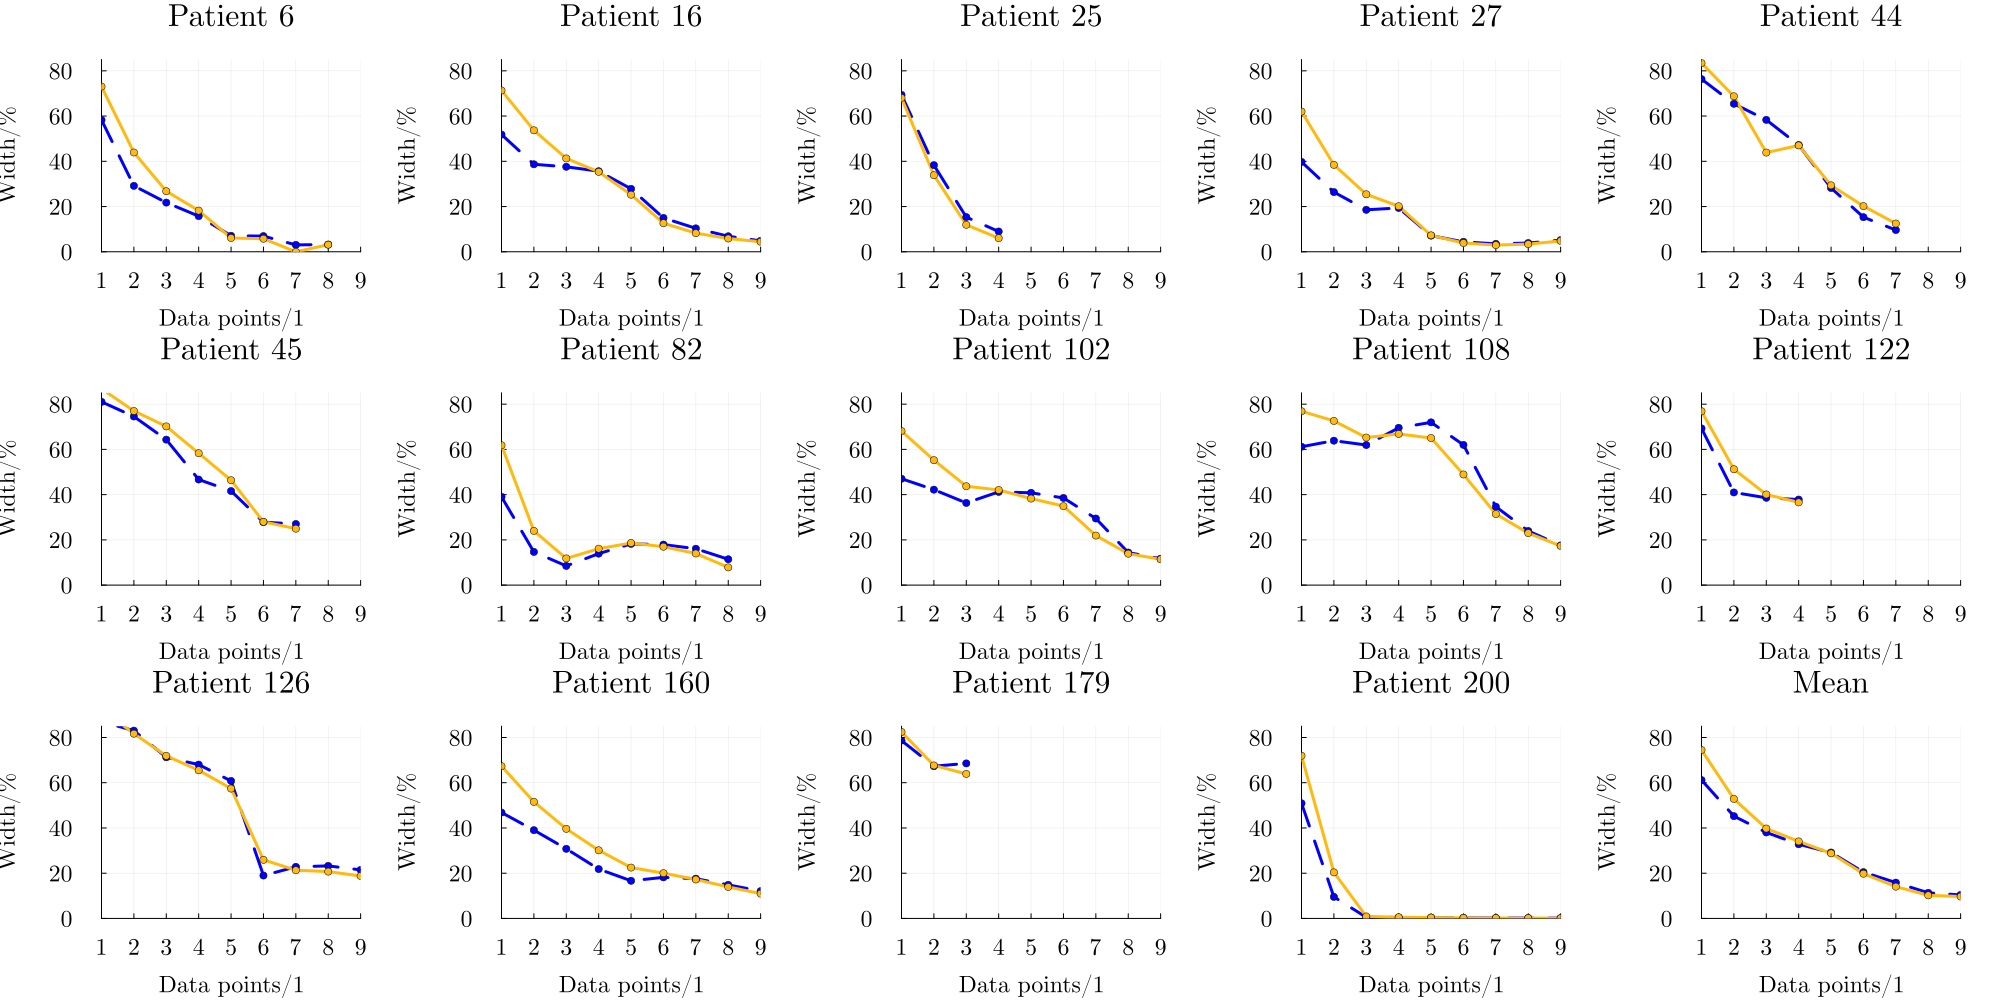

In [26]:
# Setup for all patients
meanCIwidth_plot = Any[]

# Plot meanCIwidths in loop
for i=1:length(unique_patients)
    fig1 = plot()
    plot!([1:9], meanCIwidth_mat_pre[i,:], linewidth = 3, label = "Uniform prior", colour= :blue1, xticks = (1:maxObs, 1:maxObs), 
           linestyle = :dash)
    plot!([1:9], meanCIwidth_mat[i,:], linewidth = 3, label = "Population prior", colour= :darkgoldenrod1, xticks = (1:maxObs, 1:maxObs))
    scatter!([1:9], meanCIwidth_mat_pre[i,:], markercolor=:blue1, markersize=4, markerstrokewidth=0.25, label="")
    scatter!([1:9], meanCIwidth_mat[i,:], markercolor=:darkgoldenrod1, markersize=4, markerstrokewidth=0.25, label="")
    title!("Patient $(unique_patients[i])")
    xlabel!("Data points/1")
    ylabel!("Width/%")
    plot!(legend=:none,titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15,
          size = (700, 500), margin=5mm)
    xlims!(1,9)
    ylims!(0,85)
    push!(meanCIwidth_plot,fig1)
end
# Add plot showing the mean
fig1 = plot()
plot!([1:9,], mean_meanCIwidth_vec_pre, linewidth = 3, label = "Uniform prior", colour= :blue1, xticks = (1:maxObs, 1:maxObs), 
      linestyle = :dash)
plot!([1:9,], mean_meanCIwidth_vec, linewidth = 3, label = "Population", colour= :darkgoldenrod1, xticks = (1:maxObs, 1:maxObs))
scatter!([1:9,], mean_meanCIwidth_vec_pre, markercolor=:blue1, markersize=4, markerstrokewidth=0.25, label="")
scatter!([1:9,], mean_meanCIwidth_vec, markercolor=:darkgoldenrod1, markersize=4, markerstrokewidth=0.25, label="")
title!("Mean")
xlabel!("Data points/1")
ylabel!("Width/%")
plot!(legend=:none,titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15,
      size = (700, 500), margin=5mm)
xlims!(1,9)
ylims!(0,85)
push!(meanCIwidth_plot,fig1)

# Plot everything
fig_meanCIwidth_all= plot(meanCIwidth_plot..., layout= (3,5), size = (2000, 1000), margin=8mm, leftmargin = 8mm, rightmargin = 8mm)

# Save figure
# figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/"
# savefig(fig_meanCIwidth_all,figpath*"meanCIwidth_extra_patients.png")
# savefig(fig_meanCIwidth_all,figpath*"meanCIwidth_extra_patients.pdf")
# savefig(fig_meanCIwidth_all,figpath*"meanCIwidth_extra_patients.svg")

In [15]:
# Calculate quantities of interest
mean_RMSE_vec

9-element Vector{Float64}:
 0.09905524075101753
 0.08492676820928009
 0.0782939443094715
 0.0628515530601279
 0.04626189796539646
 0.03723569850942383
 0.031834697692043175
 0.025661277347899147
 0.028214906483910344

In [16]:
mean_RMSE_vec_pre

9-element Vector{Float64}:
 0.11703317888022714
 0.09814310587169162
 0.08803120615063141
 0.07118016299023586
 0.050090783112837635
 0.03966680754047504
 0.03305191206026059
 0.02626653250943284
 0.028597605619764793

In [17]:
meanCIwidth_mat

14×9 Matrix{Float64}:
 73.0307  43.8989  26.7847    …    0.0         3.14408   NaN
 71.3151  53.7021  41.2642         8.22628     5.8749      4.42446
 68.0087  33.8623  11.9258       NaN         NaN         NaN
 61.9933  38.4428  25.414          2.95884     3.39513     4.78652
 83.4267  68.7372  43.8588        12.4868    NaN         NaN
 86.8007  76.9712  70.1603    …   24.9526    NaN         NaN
 61.8313  23.9742  11.8005        13.9823      7.84357   NaN
 68.1157  55.2423  43.7102        21.9122     13.8947     11.4237
 76.8578  72.587   65.2329        31.4145     22.9946     17.301
 76.868   51.2423  40.0757       NaN         NaN         NaN
 92.4494  81.6863  71.8838    …   21.3121     20.7146     18.7641
 67.3211  51.5448  39.6172        17.2148     13.9364     10.9738
 82.4423  67.6393  63.8957       NaN         NaN         NaN
 71.9383  20.3746   0.883778       0.199206    0.156659    0.134796

In [18]:
mean_meanCIwidth_vec

9-element Vector{Float64}:
 74.45706715084714
 52.85037661456003
 39.750546362486276
 34.06185781566369
 28.77762373997597
 19.7758539113221
 14.059958723311775
 10.217179138241185
  9.686926502343482

In [19]:
1 .- mean_RMSE_vec./mean_RMSE_vec_pre

9-element Vector{Float64}:
 0.15361402895505727
 0.13466394348361088
 0.11061147821260509
 0.11700745798025836
 0.07643891569464967
 0.061288245306118094
 0.03682735104698864
 0.023042826886888523
 0.013382209019273672

In [20]:
mean_RMSE_vec_pre .- mean_RMSE_vec

9-element Vector{Float64}:
 0.017977938129209614
 0.013216337662411523
 0.009737261841159917
 0.008328609930107964
 0.0038288851474411745
 0.002431109031051211
 0.001217214368217416
 0.0006052551615336917
 0.00038269913585444945

In [23]:
test1 = [ 0.10394711485835048
 0.09067834121820392
 0.0835069104868897
 0.06702089967662427
 0.051098718193723844
 0.04088590270435295
 0.03488724559167387
 0.02885454475133126
 0.03279915607362979]

test2 = [0.12696907081494097
 0.10740872222581736
 0.09490953422609924
 0.07675995404888857
 0.05502861786309858
 0.043565541368722836
 0.03629533900699729
 0.029488942288997552
 0.03329682580954131]

9-element Vector{Float64}:
 0.12696907081494097
 0.10740872222581736
 0.09490953422609924
 0.07675995404888857
 0.05502861786309858
 0.043565541368722836
 0.03629533900699729
 0.029488942288997552
 0.03329682580954131

In [ ]:
using Plots
plot(test1)
plot!(test2)